## Objectif
Ce notebook vise à explorer les techniques d'augmentation de données d'images et à construire un modèle de classification pour identifier les pneumonies à partir d'images de rayons X. Les étapes clés incluent l'augmentation des données, l'entraînement d'un modèle CNN et l'évaluation des performances du modèle.

## Étapes de Démarche

1. **Vérification de la Disponibilité du GPU**
2. **Chargement et Préparation des Données**
   - Chargement, redimensionnement, conversion en niveaux de gris, normalisation et restructuration des images.
3. **Visualisation des Données**
4. **Augmentation des Données**
5. **Définition et Entraînement du Modèle CNN**
6. **Évaluation du Modèle**
7. **Visualisation des Performances**
   - Matrice de confusion, rapport de classification et courbe ROC.
8. **Heatmaps des Activations**

## Interprétation et Résultats
- **Courbes d'Apprentissage** : convergence du modèle et relation entre la perte et l'exactitude.
- **Matrice de Confusion** : répartition des erreurs de classification.
- **Rapport de Classification** : mesures détaillées comme la précision, le rappel et le score F1.
- **Courbe ROC** : capacité du modèle à distinguer les classes à différents seuils.
- **Heatmaps des Activations** : caractéristiques extraites par les couches du modèle.ion des données d'entrée.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import seaborn as sns

Vérifie si des GPUs sont disponibles parce que si ils le sont alors ça accélère les calculs lors de l'entraînement du modèle, donc ça réduit le temps d'entaînement

In [7]:
print("Nombre de GPUs disponibles : ", len(tf.config.experimental.list_physical_devices('GPU')))

Nombre de GPUs disponibles :  0


Définition des constantes

In [12]:
img_size = 150 #150x150 pixels
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

Charger et prétraiter les images à partir des 2 répertoires spécifiés. Cette fonction prend en entrée deux chemins de répertoire (data_dir1 et data_dir2) et retourne un tableau contenant les images redimensionnées et leurs étiquettes respectives.

In [15]:
def load_data(data_dir1, data_dir2):
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas.")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Échec de lecture de {img}. Ignoré.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train_data = load_data(data_dir1, data_dir2)

Visualisation du nombre d'images par classe

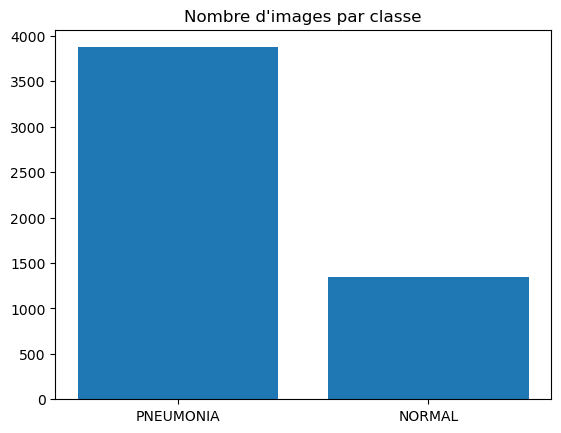

In [17]:
labels_count = [0, 0]
for item in train_data:
    labels_count[item[1]] += 1

plt.bar(['PNEUMONIA', 'NORMAL'], labels_count)
plt.title('Nombre d\'images par classe')
plt.show()

Prendre en entrée les données (features et labels) et les sépare en deux tableaux distincts : un pour les features (images) et un autre pour les labels (étiquettes de classe).

- **Normaliser** : 
  - Chaque pixel d'une image a une valeur entre 0 et 255.
  - Normaliser signifie diviser ces valeurs par 255 pour qu'elles soient entre 0 et 1.
 Caela facilite l'entraînement du modèparce quecar les valeurs sont plus petites et plus uniformes.

- **Reshaper** :
  - Les images sont des tableaux de nombres (valeurs des pixels).
  - Reveut direignifie réorganiser ces tableaux pour qu'ils aient une forme spécifique.
  - On veut que chaque image ait la forme (nombre d'images, 150, 150, 1).
  - Cela indique qu'on a un certain nombre d'images, que chaque image a une taille de 150x150 pixels, et qu'elle est en niveaux de gris (1 canal de couleur).


In [21]:
def separate_features_labels(data):
    features, labels = [], []
    # séparation des features et des labels
    for feature, label in data:
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

#normaliser les données en divisant par 255
x_train, y_train = separate_features_labels(train_data)

# Normaliser les données
x_train = x_train / 255.0
x_train = x_train.reshape(-1, img_size, img_size, 1)

On vérifie si les tableaux des données x_train et y_train ne sont pas vide et si ils ne sont pas vide alors on crée un générateur d'images (datagen) pour augmenter les données de l'entraînement avec des décalages horizontaux et verticaux. Donc on a plus de diversité dans les données de l'entraînement.

In [30]:
if x_train.size == 0 or y_train.size == 0:
    print("Les données d'entraînement sont vides. Veuillez vérifier le processus de chargement des données.")
else:
    datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )
    datagen.fit(x_train)

Affichage de quelques exemples d'images augmentées.

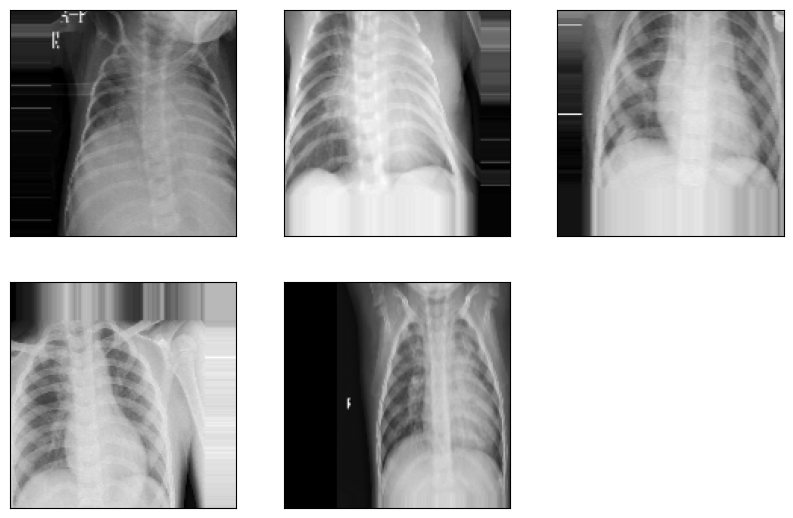

In [33]:
def display_augmented_images(datagen, x_train, y_train):
    plt.figure(figsize=(10, 10))
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=5):
        for i in range(5):
            plt.subplot(330 + 1 + i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(x_batch[i].reshape(img_size, img_size), cmap='gray')
        plt.show()
        break

display_augmented_images(datagen, x_train, y_train)

Création d'un modèle CNN :

- Couche de convolution : extrait les caractéristiques d'une imae.
- Couche de pooling : réduit la taille de l'image en conservant les caractéristiques importanes.
- Couche de dropout : réduit le surapprentissage en désactivant des neurones aléatoireent.
- Couche dense : couche de neurones entièrement connectés pour la classifiction.
- Les c (unité de calcul dans un réseau de neurones)ouches sont empilées pour former le odèle.
- Compilation du modèle avec l'optimiseu(optimiseur pour ajuster les poids du modèle) r Adam et la perte cross- (mesure la différence entre prédictions et vraies étiquettes)ntropy.

In [36]:
# Définir le modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Configuration des callbacks pour ajuster le taux d'apprentissage (reduce_lr) et arrêter l'entraînement si la perte ne diminue plus (early_stop). Ensuite, le modèle est entraîné avec les données augmentées.

In [39]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)
early_stop = EarlyStopping(monitor='loss', patience=3)

# enyrainement du modèle avec les données augmentées
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10, callbacks=[reduce_lr, early_stop])

Epoch 1/10


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 461ms/step - accuracy: 0.6797 - loss: 0.8650 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 456ms/step - accuracy: 0.7385 - loss: 0.5165 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 431ms/step - accuracy: 0.7397 - loss: 0.4905 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 407ms/step - accuracy: 0.7847 - loss: 0.3997 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 446ms/step - accuracy: 0.7999 - loss: 0.3628 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 430ms/step - accuracy: 0.8121 - loss: 0.3433 - learning_rate: 0.0010
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 440ms/step - accuracy: 0.8228 - loss: 0.3022 - learning_rate: 0.0010
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 427ms/step - accuracy: 0.8827 - loss: 0.3004 - learning_rate: 0.0010
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 461ms/step - accuracy: 0.8960 - loss: 0.2668 - learning_rate: 0

Affichage des courbes de perte et d'exactitude pendant l'entraînement. Ca permet de voir les performance du modèle avec les Epochs (Epoques).

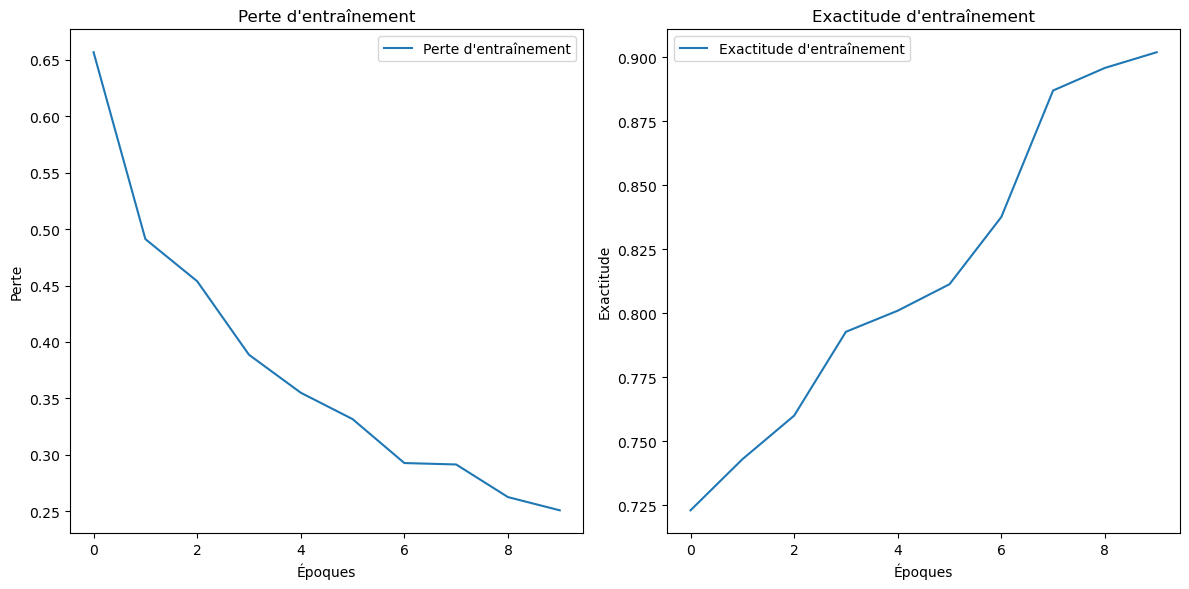

In [42]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))

    # Courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Perte d\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.title('Perte d\'entraînement')
    plt.legend()

    # Courbe d'exactitude
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Exactitude d\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Exactitude')
    plt.title('Exactitude d\'entraînement')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

Evaluation du modèle sur les données de l'entraînement et affiche l'exactitude et la perte. Ensuite, on affiche quelques images avec les prédictions du modèle qu'on a entraîné

Exactitude du modèle : 89.03%
Perte du modèle : 0.2254
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step


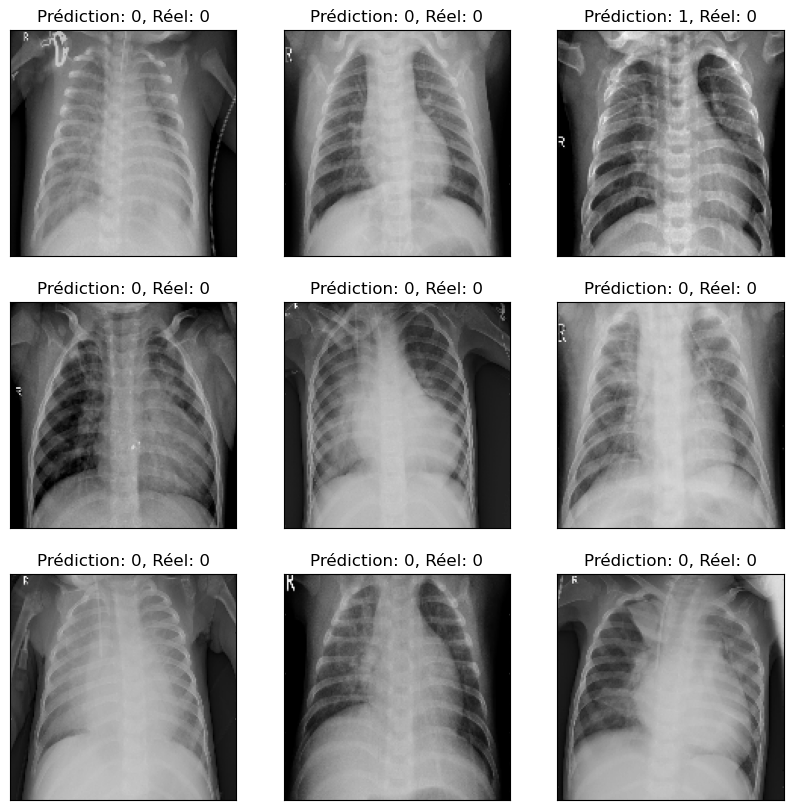

In [45]:
# evaluation du modèle
scores = model.evaluate(x_train, y_train, verbose=0)
print(f"Exactitude du modèle : {scores[1]*100:.2f}%")
print(f"Perte du modèle : {scores[0]:.4f}")

# afficher les prédictions
def display_predictions(model, x_train, y_train):
    plt.figure(figsize=(10, 10))
    predictions = (model.predict(x_train) > 0.5).astype("int32")
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_train[i].reshape(img_size, img_size), cmap='gray')
        plt.title(f"Prédiction: {predictions[i][0]}, Réel: {y_train[i]}")
    plt.show()

display_predictions(model, x_train, y_train)

Matrice de confusion et rapport de classification pour évaluer la performance du modèle en termes de précision, rappel (proportion d'images correctement identifiées comme ayant une pneumonie) et F1-score (moyenne harmonique de la précision et du rappel : `F1 = (2*(précision*rappel))/(précision+rappel)` pour chaque classe.$


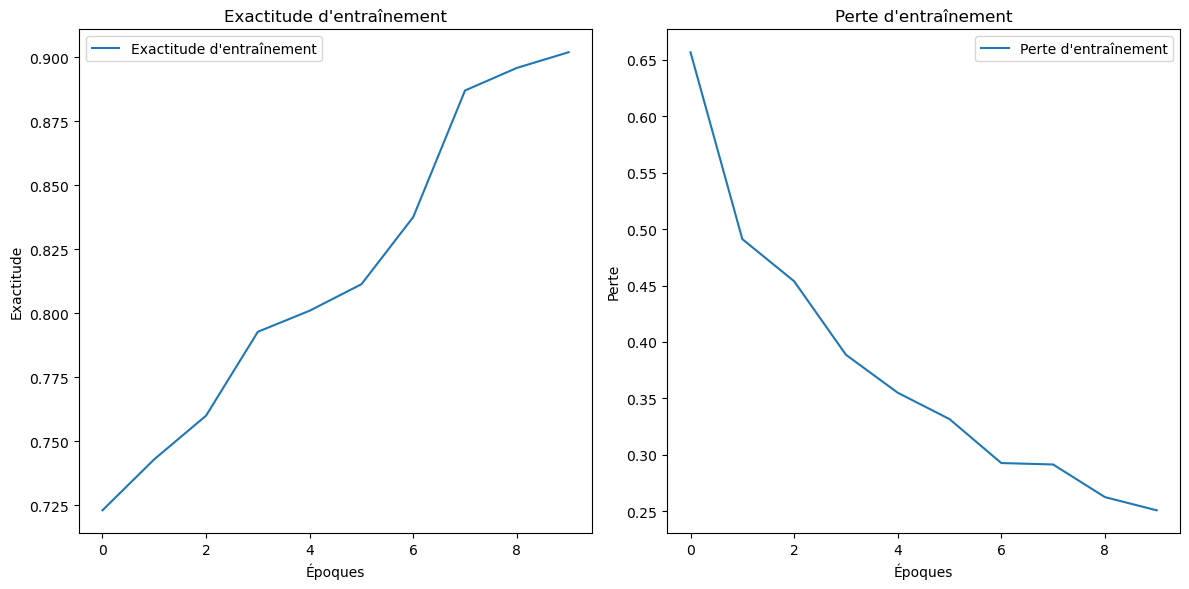

In [48]:
# Matrice de confusion
y_pred = (model.predict(x_train) > 0.5).astype("int32")
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PNEUMONIA', 'NORMAL'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()

# Rapport de classification
print(classification_report(y_train, y_pred, target_names=['PNEUMONIA', 'NORMAL']))